### This notebook is used to compute scatter plots between variables and PSD amplitude
This is a preview step before choosing which correlations can be computed

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
psd_dir = f"../../../../../data/test_correlation/data_mahy"

# Name and unit catalog for each variable
var_info = {
    "wind_speed": ("Wind speed", "m/s"),
    "current_speed": ("Current speed", "m/s"),
    "total_precipitation": ("Total precipitation", "m"),
    "wave_height": ("Wave height", "m"),
    "wave_period": ("Wave period", "s"),
}

# Possible hydrophones
hydrophones = [1, 2, 3, 4]
# Variables
variables = ["wind_speed", "current_speed", "total_precipitation", "wave_height", "wave_period", ]

In [10]:
# # Sum of frequencies on frequency range 0-20 Hz
# freqs = psd_df.columns.astype(float)
# freq_mask = (freqs >=0) & (freqs <= 20.15625)
# selected_columns = psd_df.columns[freq_mask]
#
# psd_df['amplitude_totale'] = psd_df[selected_columns].sum(axis=1)

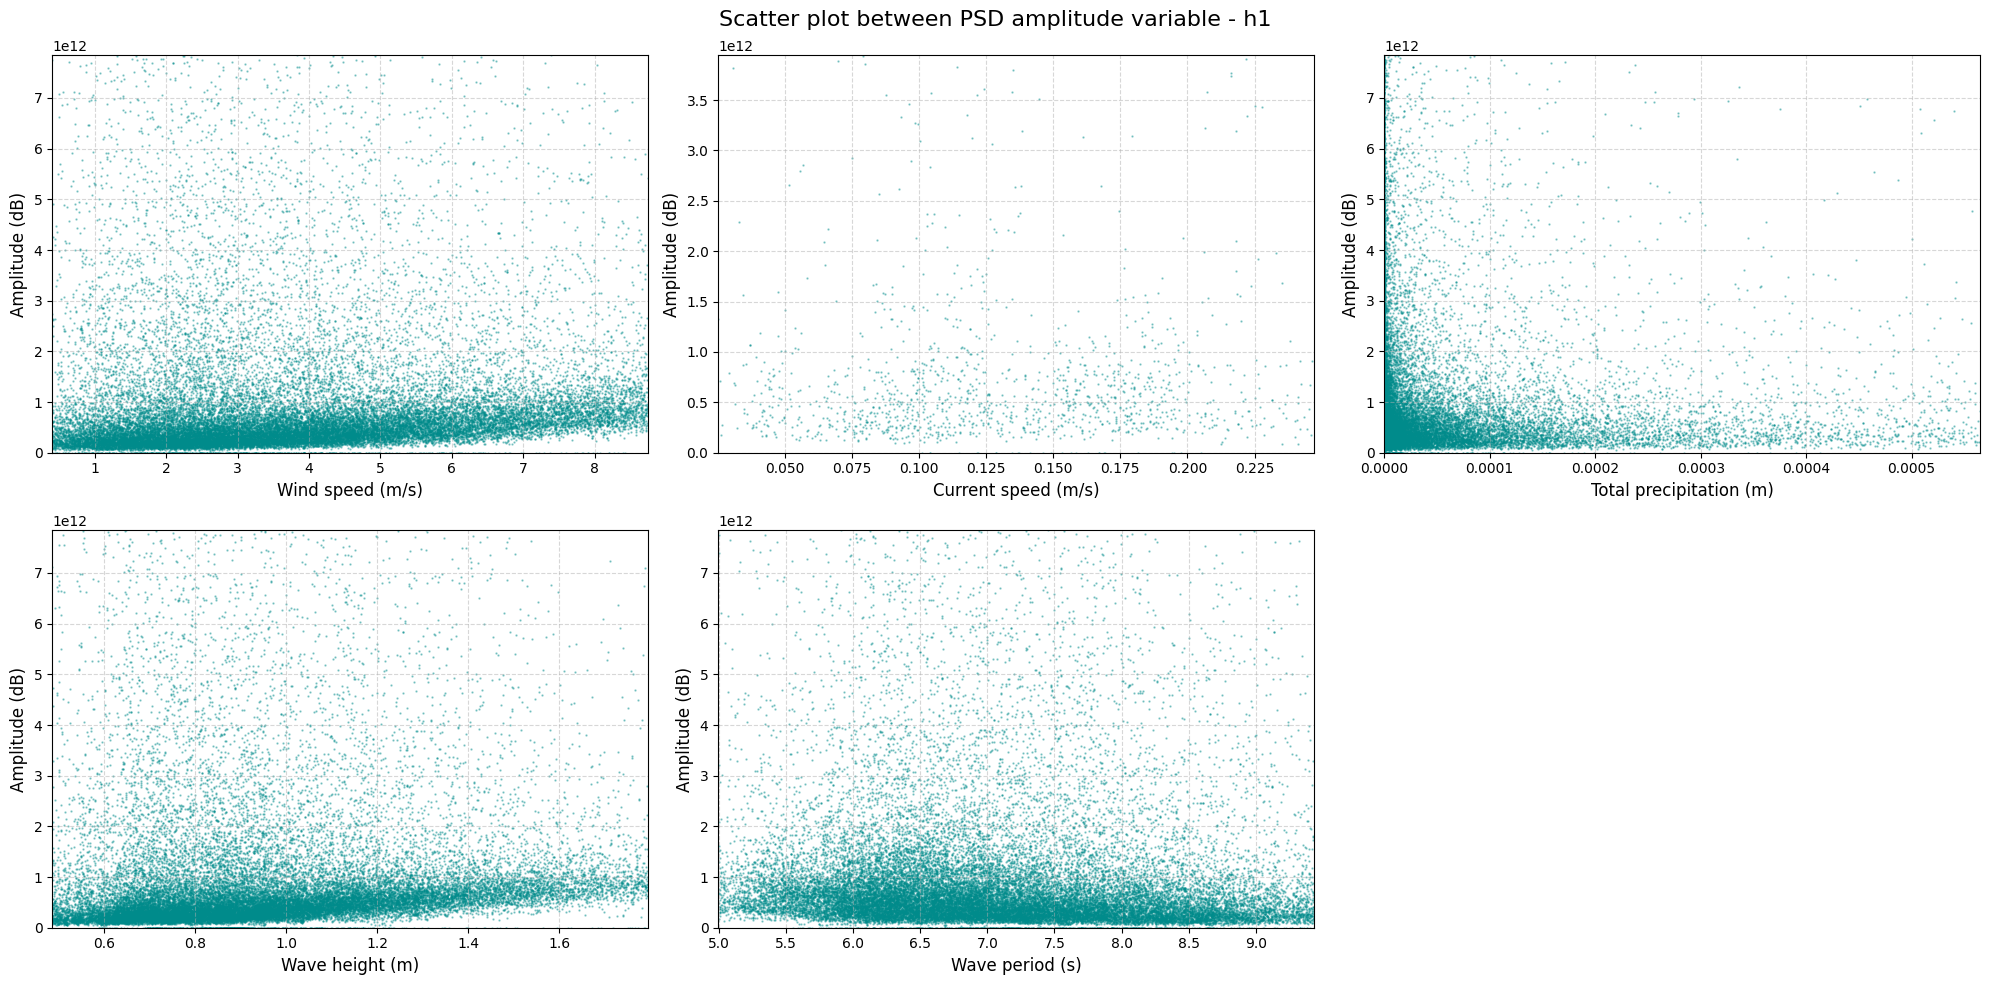

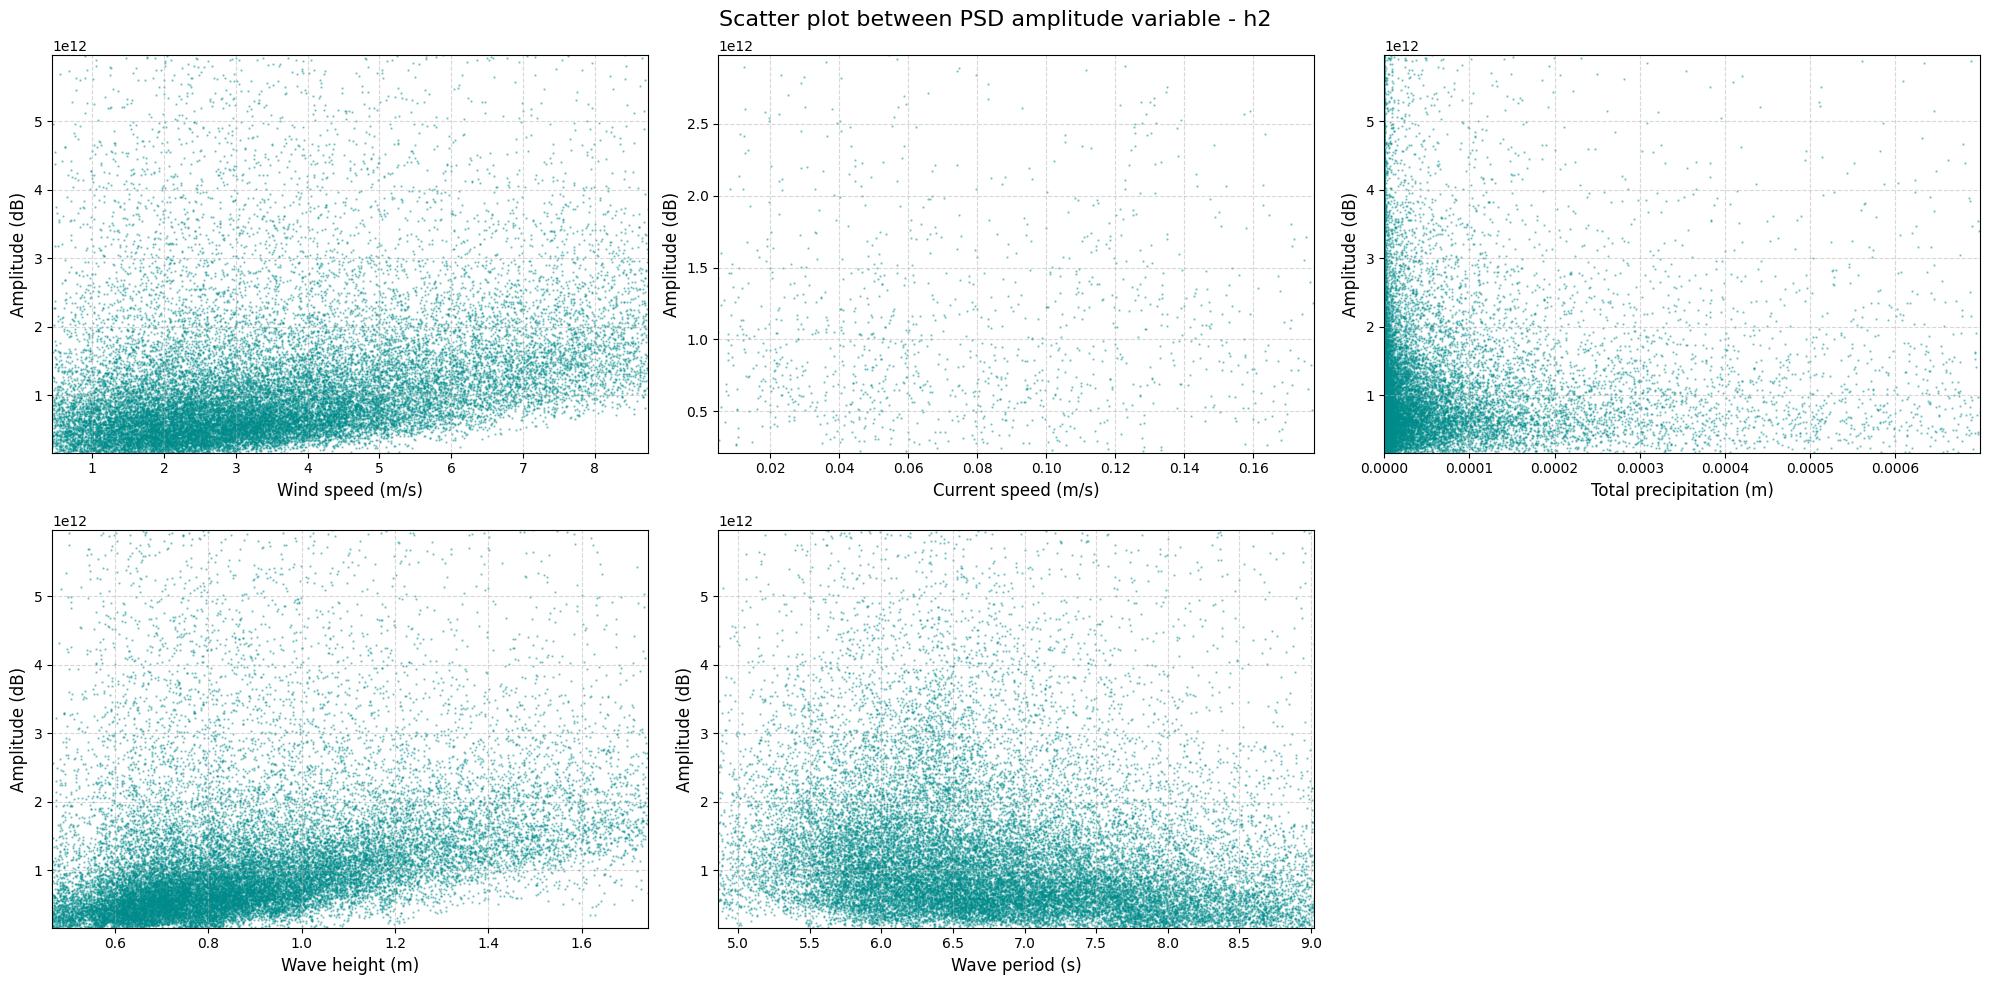

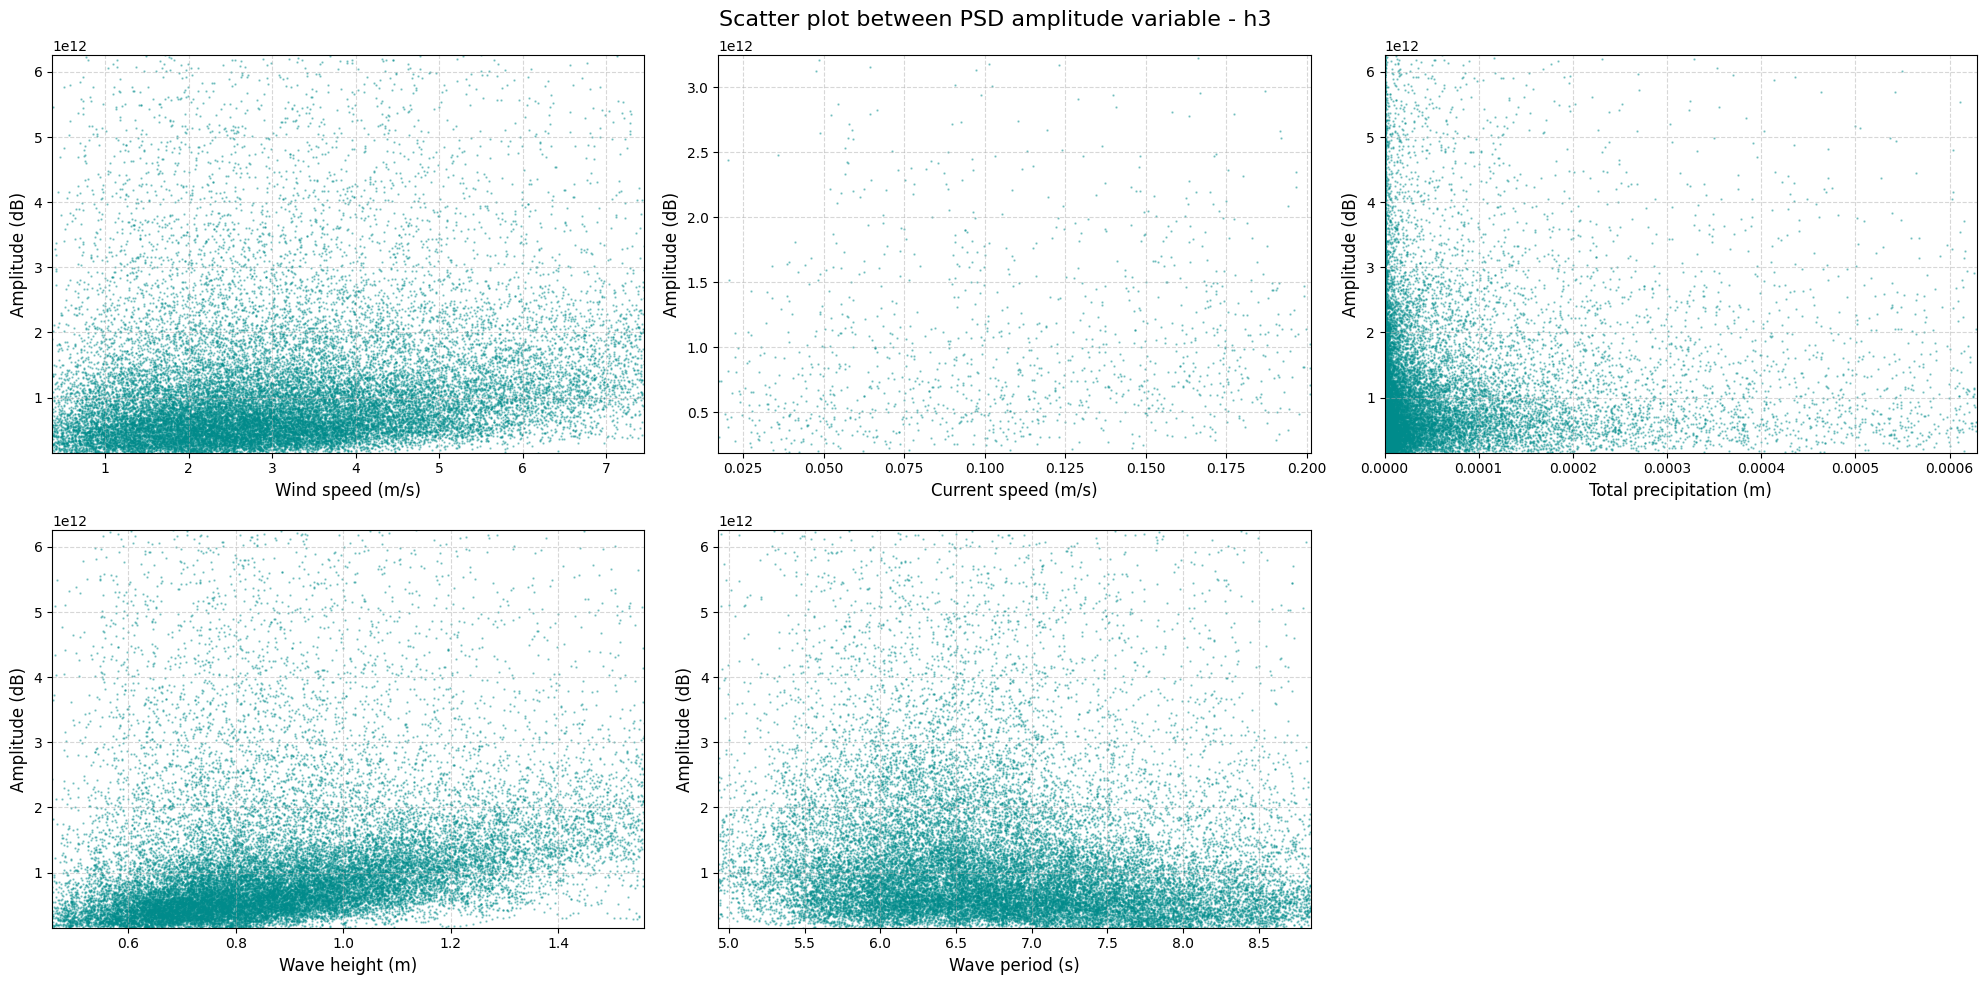

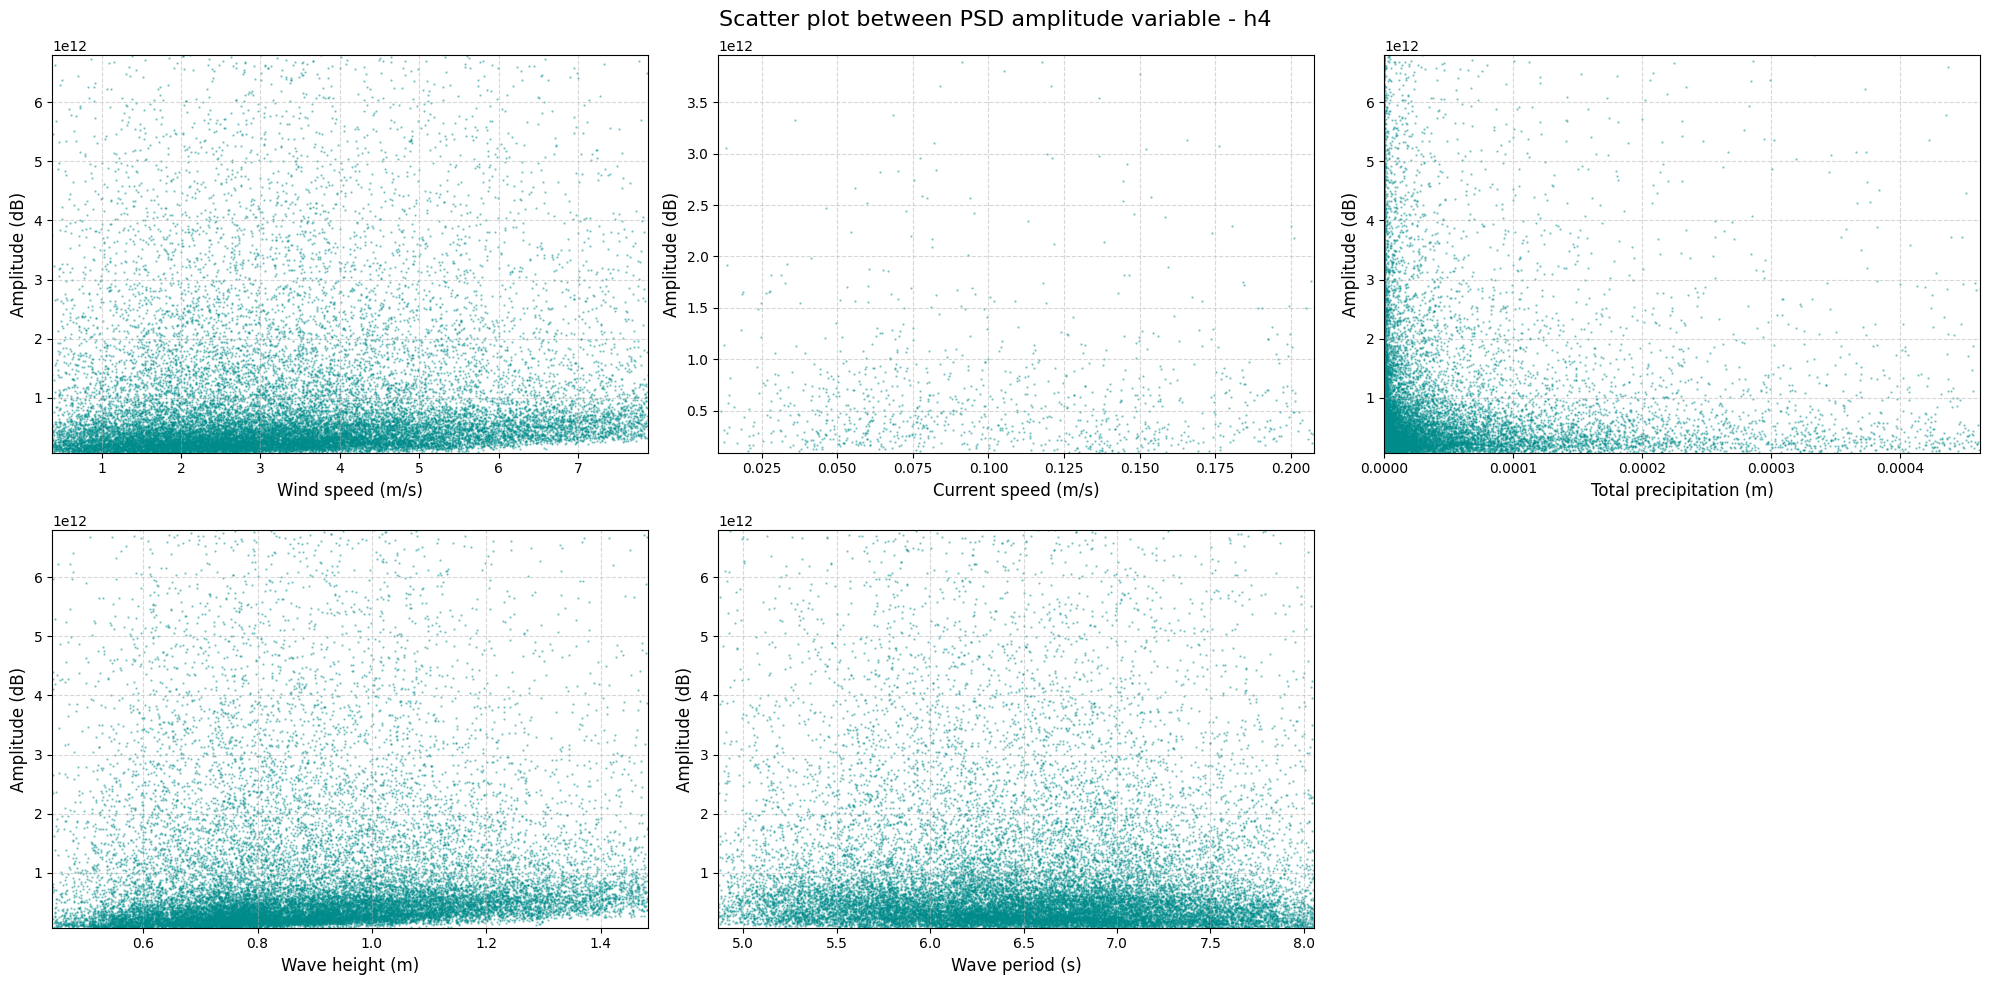

In [11]:
# select the stations you want to plot. /!\ You can only choose stations for one hydrophone
# Scatter plot
for h in hydrophones:
    # Read PSDs
    psd_df = pd.read_pickle(os.path.join(psd_dir, f"MAHY_h{h}_concat.pkl"))
    # Sum of amplitudes for all frequencies
    psd_df['amplitude_totale'] = psd_df.sum(axis=1)

    # Initiate plot
    fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
    axs = ax.flatten()
    for j in range(5,6):
        axs[j].axis('off')

    # Loop for each variable
    for i, var in enumerate(variables):
        var_name, unit = var_info.get(var, ("Unknown variable", ""))

        variable_dir = f"../../../../../data/test_correlation/data_soundscape/{var}/h{h}.pkl"
        variable_df = pd.read_pickle(variable_dir)

        psd_df.index = pd.to_datetime(psd_df.index)
        variable_df.index = pd.to_datetime(variable_df.index)

        if var == "current_speed":
            # Apply median daily filter on amplitude
            amplitude_daily = psd_df['amplitude_totale'].resample('D').median()
            # Merge with daily variable
            df_merged = pd.merge(amplitude_daily, variable_df, left_index=True, right_index=True, how='inner')
        else:
            # Merge by time index
            df_merged = psd_df[['amplitude_totale']].merge(variable_df, left_index=True, right_index=True, how='inner')


        #Filter by quantiles (1%-95%)
        low_env, high_env = df_merged['values'].quantile([0.01, 0.95])
        low_amp, high_amp = df_merged['amplitude_totale'].quantile([0.01, 0.95])

        df_merged = df_merged[
            (df_merged['values'].between(low_env, high_env)) &
            (df_merged['amplitude_totale'].between(low_amp, high_amp))
        ]

        # Plot

        ax = axs[i]
        ax.scatter(df_merged['values'], df_merged['amplitude_totale'], alpha = 0.4, s=0.5, color='darkcyan')
        ax.set_ylabel("Amplitude (dB)", fontsize=12)
        ax.set_xlabel(f"{var_name} ({unit})", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)

        ax.set_xlim(low_env, high_env)
        ax.set_ylim(low_amp, high_amp)

    fig.suptitle(f"Scatter plot between PSD amplitude variable - h{h}", fontsize=16)
    plt.tight_layout()
    # plt.show()

    # Save figure
    output_path = f"/home/imonge/Documents/Abiotic"
    # os.makedirs(output_path, exist_ok=True)
    fig.savefig(os.path.join(output_path, f"scatter_h{h}.png"))

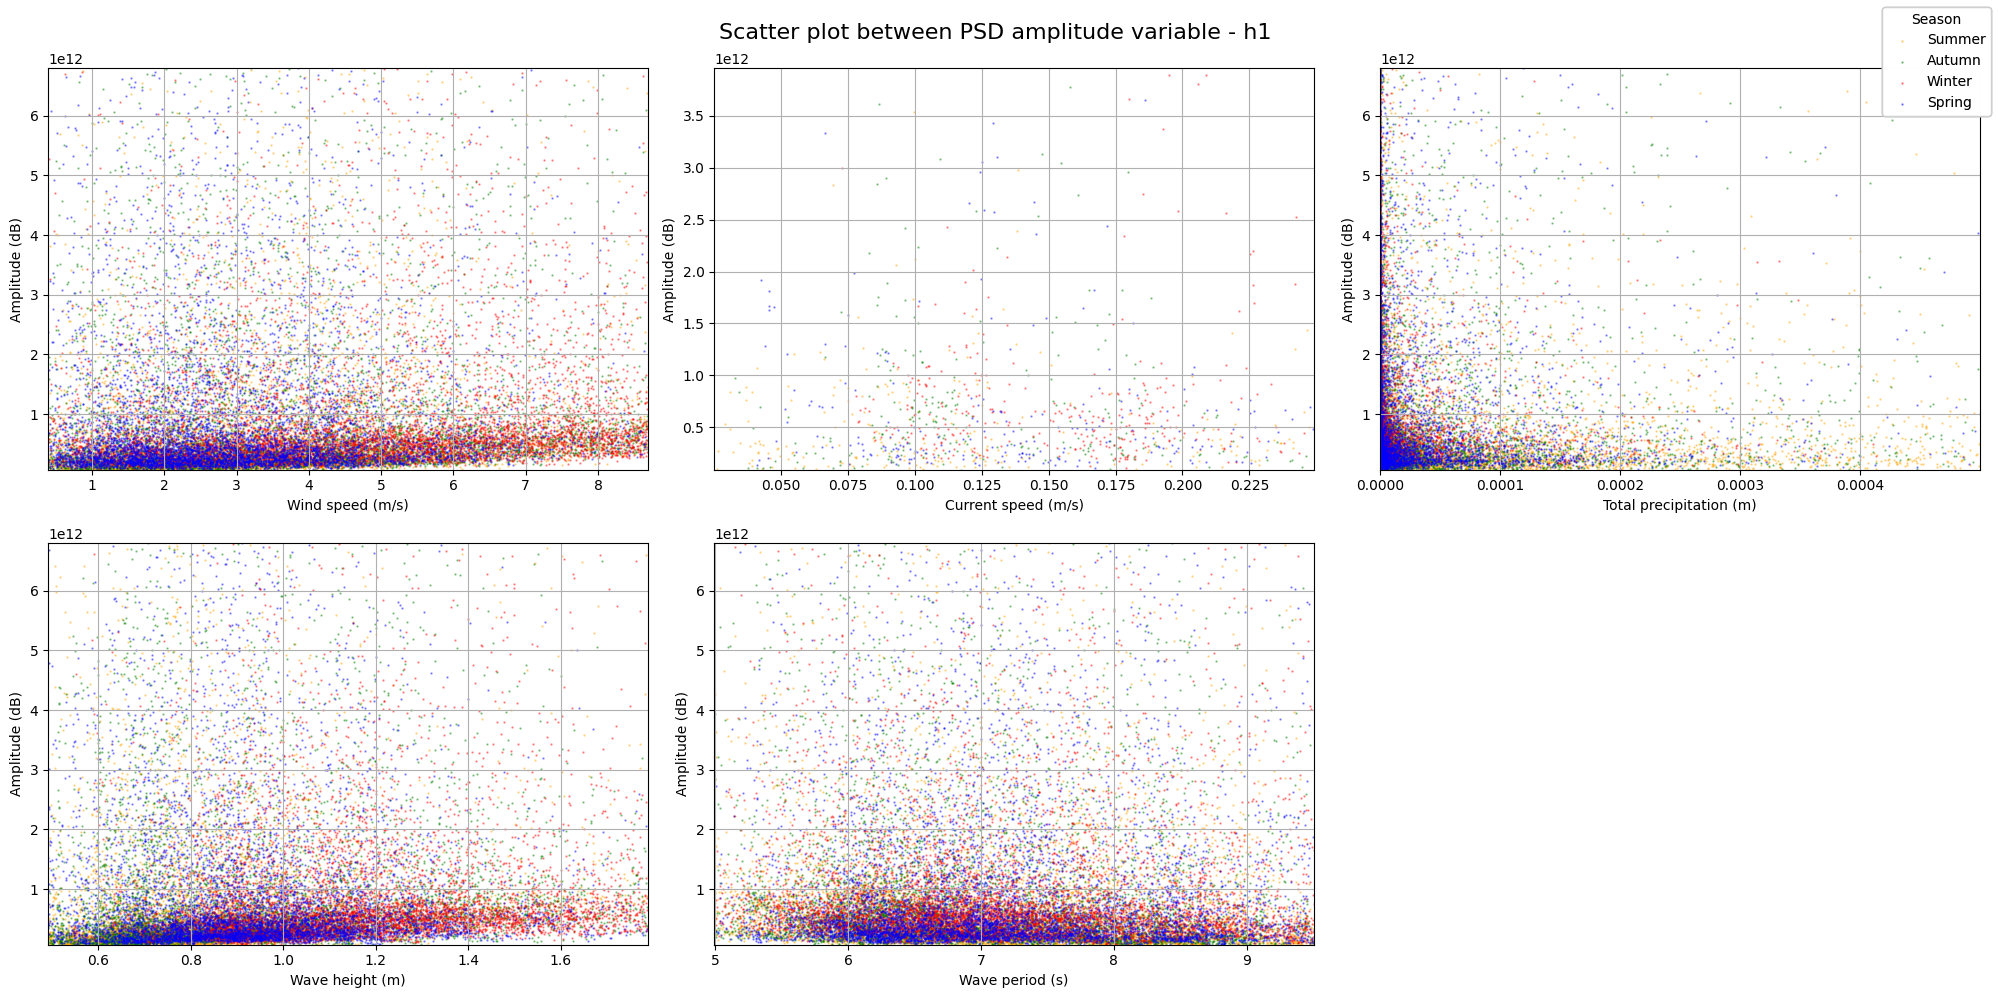

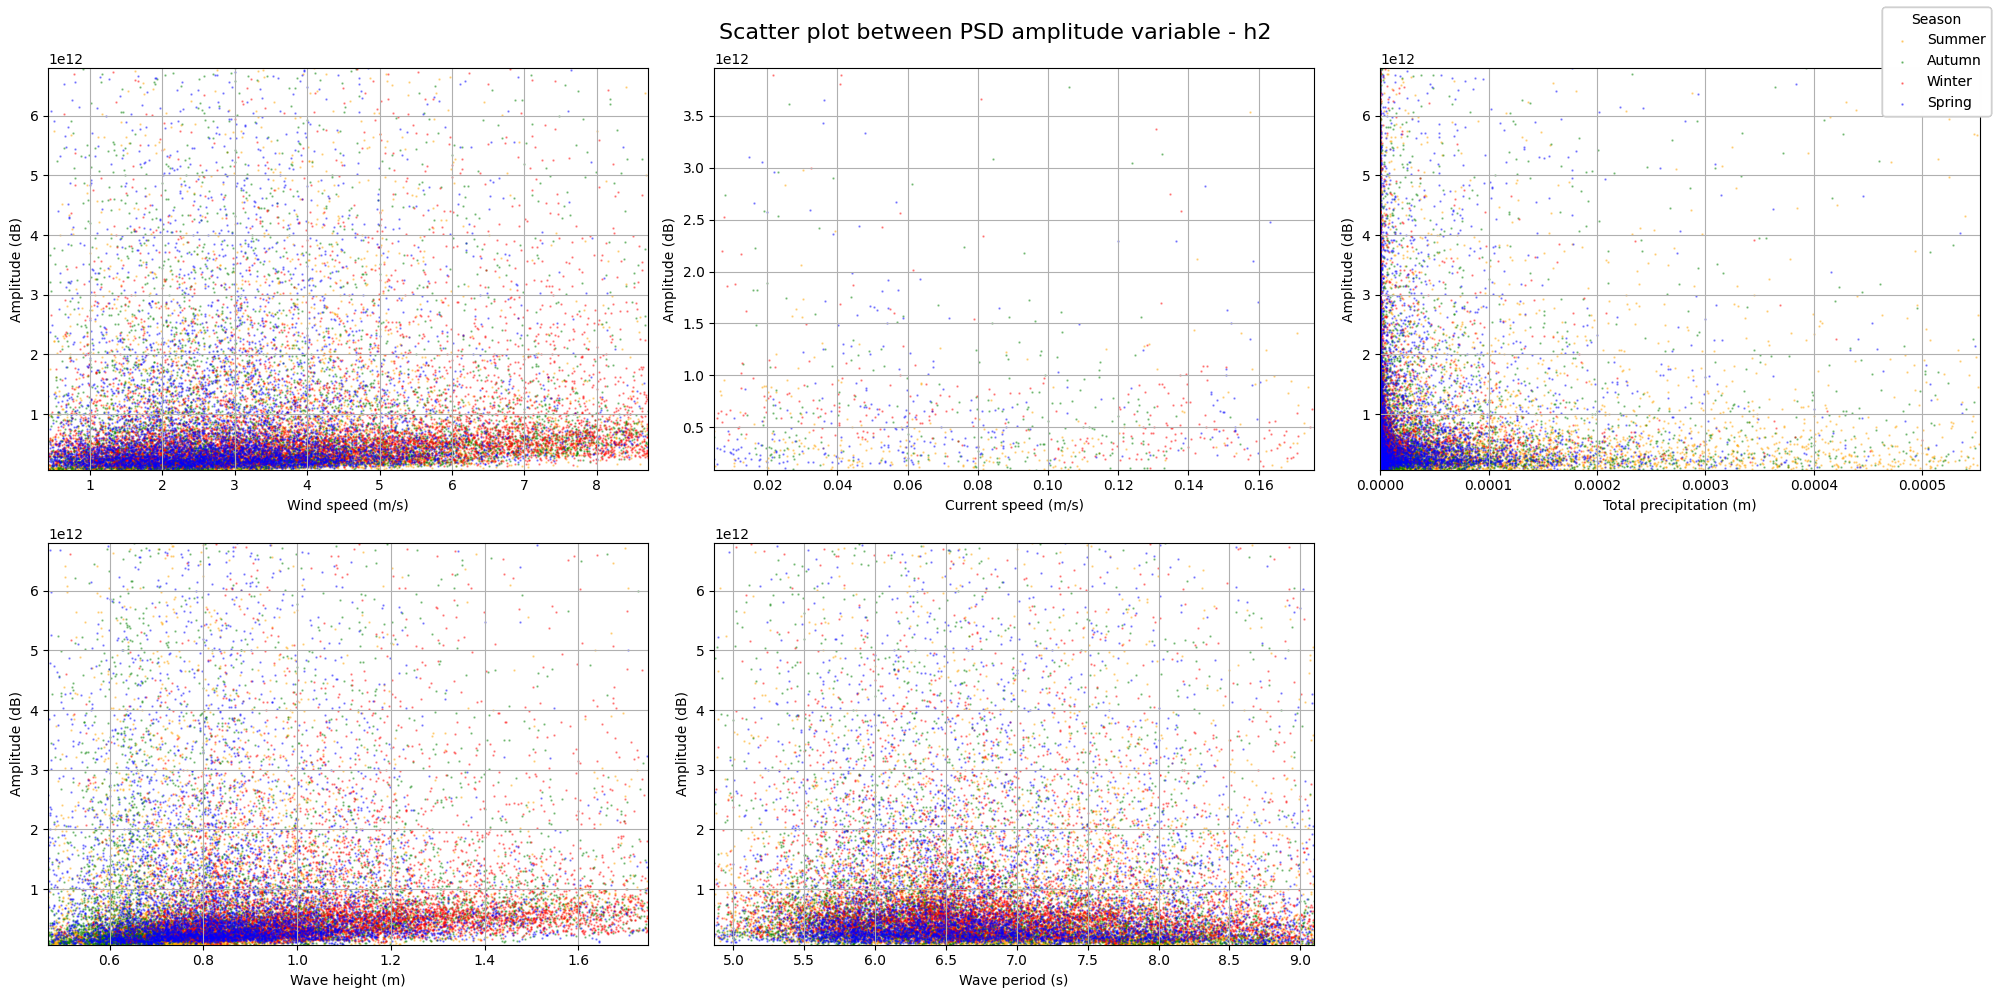

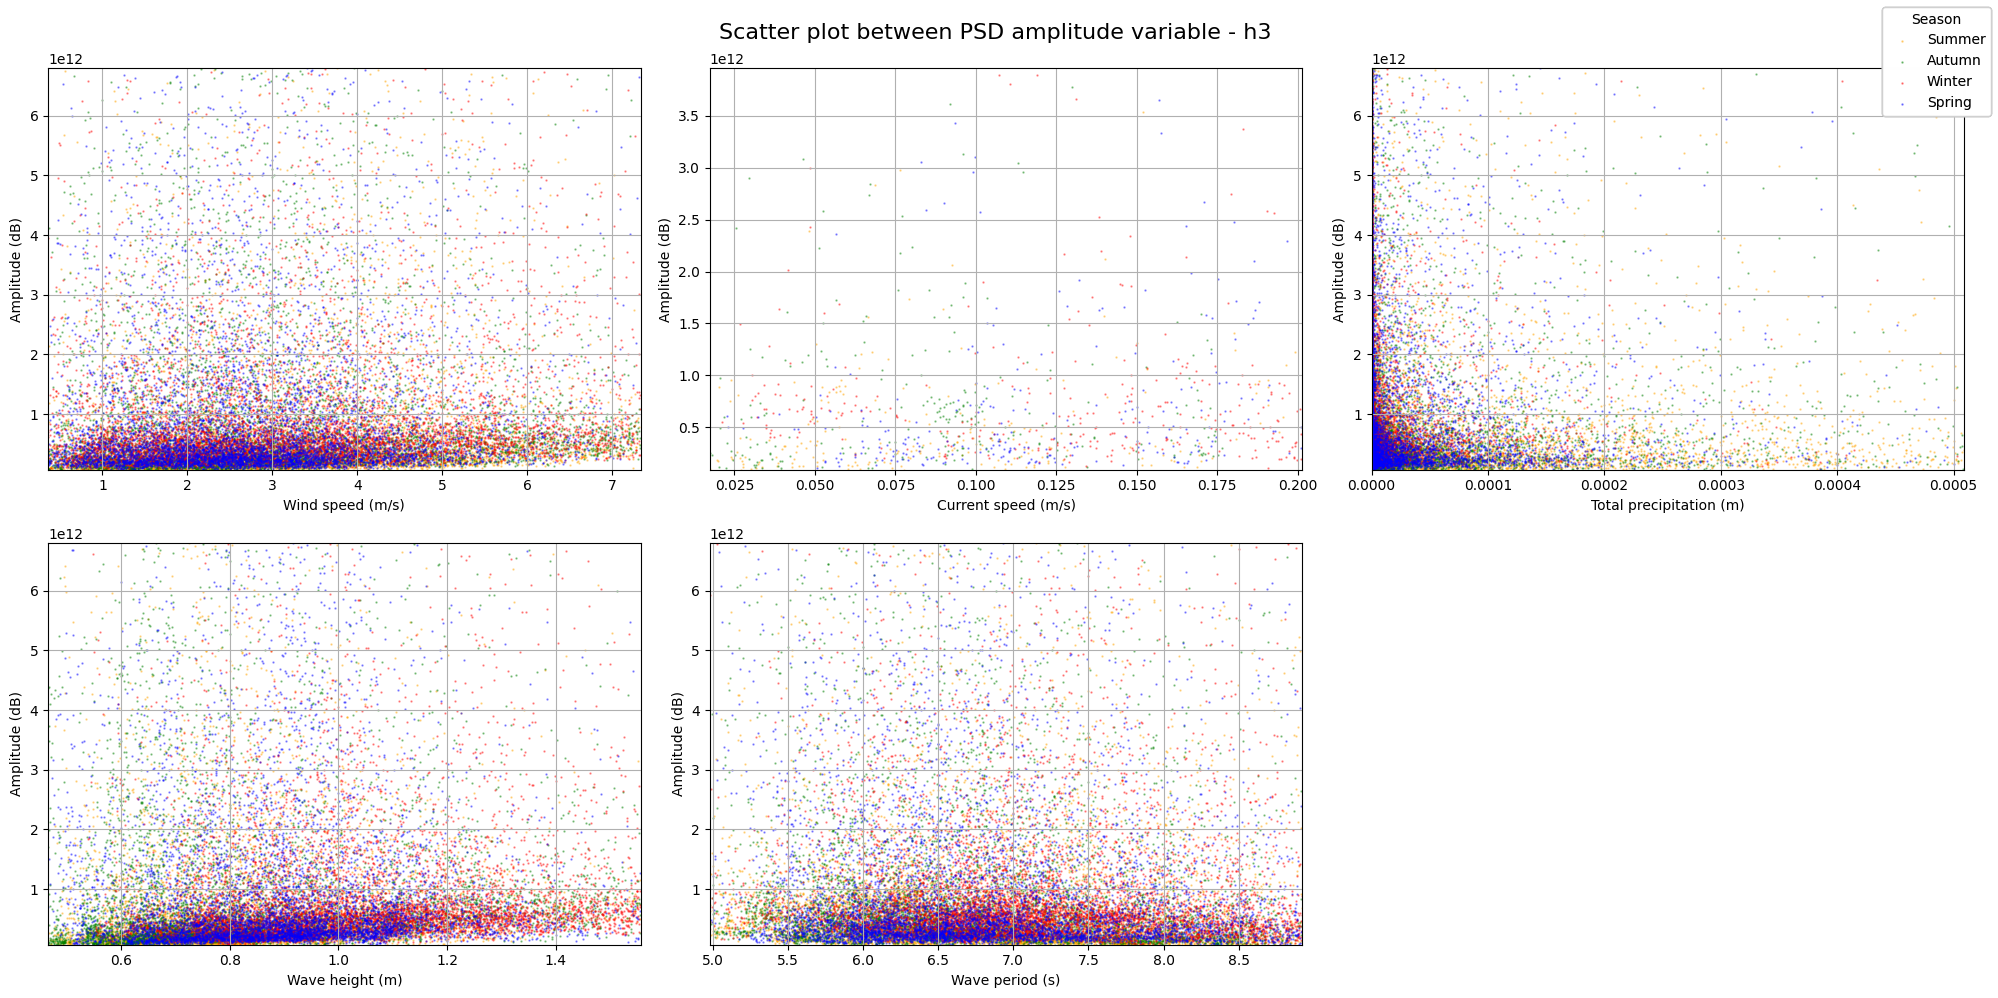

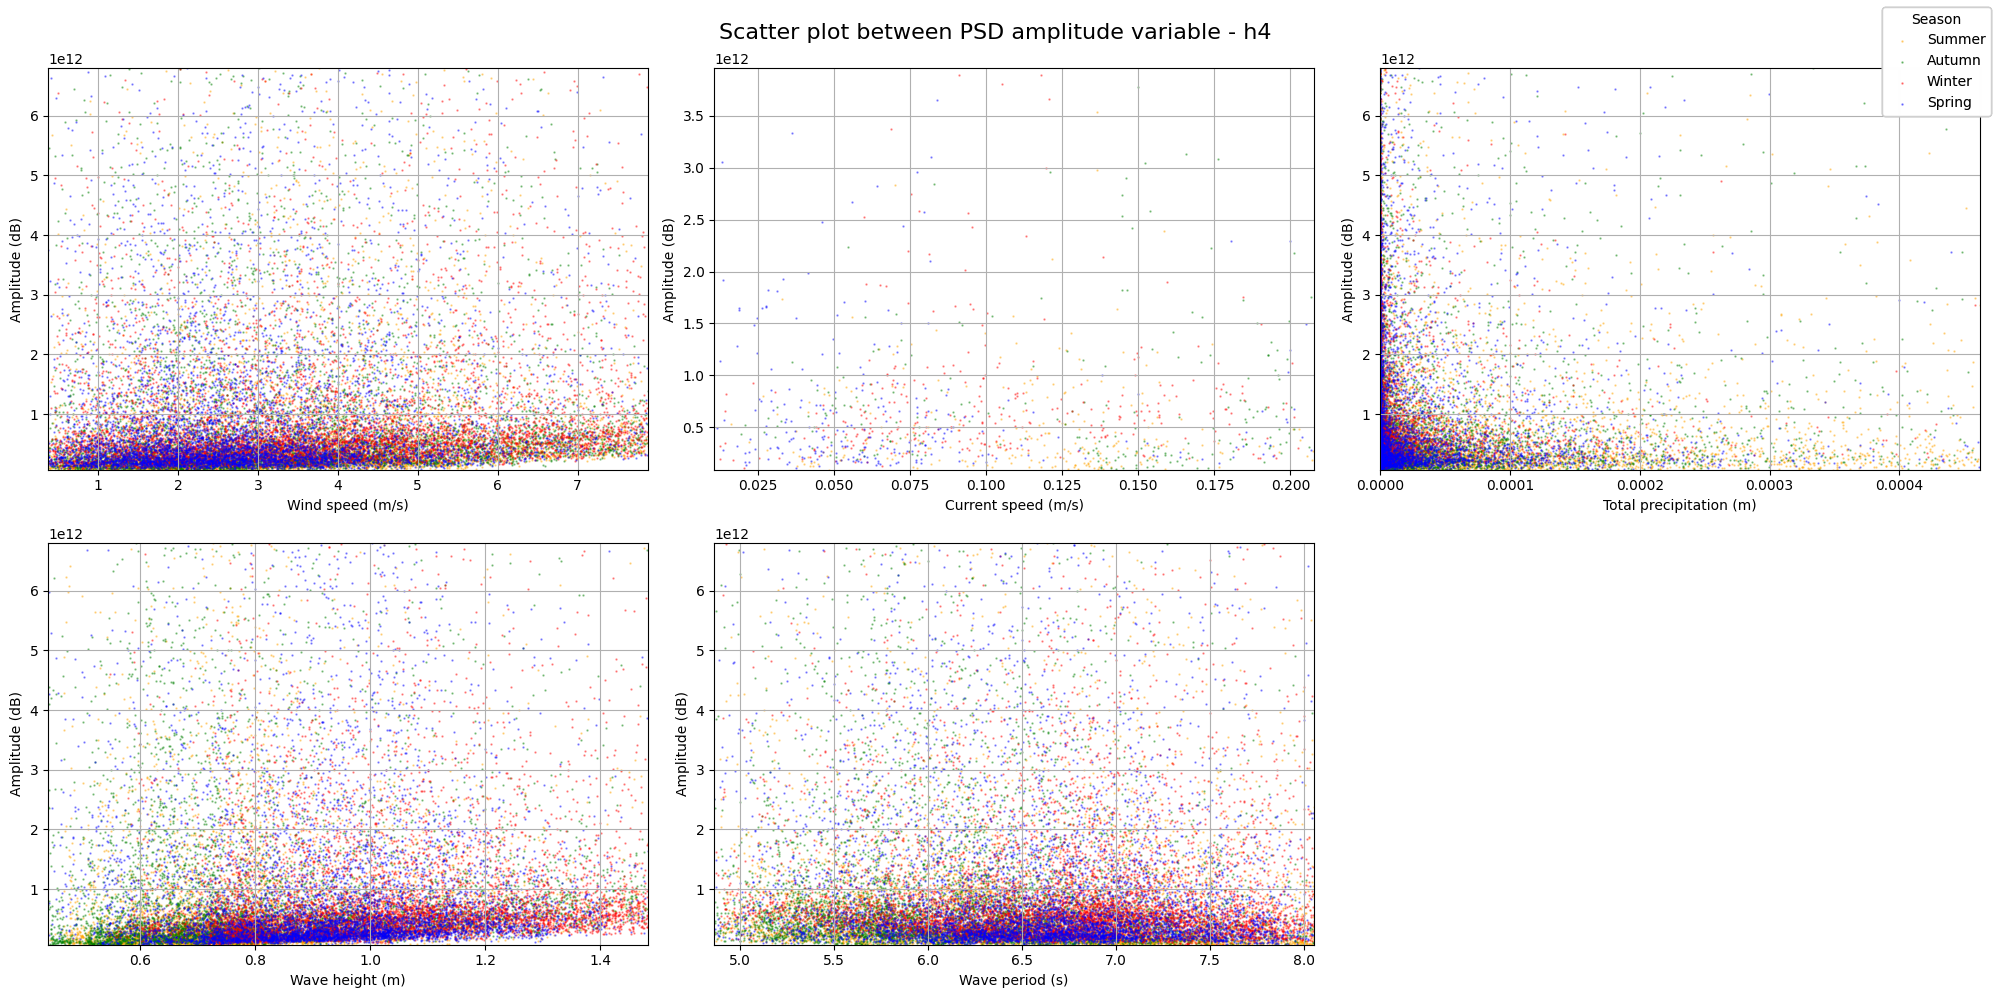

In [12]:
# # With season targets
# # Ajouter un target de saison
# def southern_hemisphere_season(date):
#     month = date.month
#     if month in [12, 1, 2]:
#         return "Summer"
#     elif month in [3, 4, 5]:
#         return "Autumn"
#     elif month in [6, 7, 8]:
#         return "Winter"
#     else:
#         return "Spring"
#
#
# season_order = ["Summer", "Autumn", "Winter", "Spring"]
# season_colors = {
#     "Summer": "orange",
#     "Autumn": "green",
#     "Winter": "red",
#     "Spring": "blue"
# }
#
# # Scatter plot
# for h in hydrophones:
#     fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
#     axs = ax.flatten()
#     for j in range(5,6):
#         axs[j].axis('off')
#     for i, var in enumerate(variables):
#
#         var_name, unit = var_info.get(var, ("Unknown variable", ""))
#
#         variable_dir = f"../../../../../data/test_correlation/data_soundscape/{var}/h{h}.pkl"
#         variable_df = pd.read_pickle(variable_dir)
#
#         psd_df.index = pd.to_datetime(psd_df.index)
#         variable_df.index = pd.to_datetime(variable_df.index)
#
#         if var == "current_speed":
#             # Apply median daily filter on amplitude
#             amplitude_daily = psd_df['amplitude_totale'].resample('D').median()
#             # Merge with daily variable
#             df_merged = pd.merge(amplitude_daily, variable_df, left_index=True, right_index=True, how='inner')
#         else:
#             # Merge by time index
#             df_merged = psd_df[['amplitude_totale']].merge(variable_df, left_index=True, right_index=True, how='inner')
#
#
#         #Filter by quantiles (1%-99%)
#         low_env, high_env = df_merged['values'].quantile([0.01, 0.95])
#         low_amp, high_amp = df_merged['amplitude_totale'].quantile([0.01, 0.95])
#
#         df_merged = df_merged[
#             (df_merged['values'].between(low_env, high_env)) &
#             (df_merged['amplitude_totale'].between(low_amp, high_amp))
#         ]
#
#         df_merged = df_merged.copy()
#         df_merged["season"] = df_merged.index.to_series().apply(southern_hemisphere_season)
#         df_merged["season"] = pd.Categorical(df_merged["season"], categories=season_order, ordered=True)
#
#         # Plot
#         ax = axs[i]
#         for season in season_order:
#             df_season = df_merged[df_merged["season"] == season]
#             ax.scatter(df_season['values'], df_season['amplitude_totale'], alpha = 0.4, label=season, s=0.5, color=season_colors[season])
#
#
#         handles, labels = axs[0].get_legend_handles_labels()
#         fig.legend(handles, labels, loc='upper right', title='Season')
#         ax.set_ylabel("Amplitude (dB)", fontsize=10)
#         ax.set_xlabel(f"{var_name} ({unit})", fontsize=10)
#         ax.grid(True)
#
#         ax.set_xlim(low_env, high_env)
#         ax.set_ylim(low_amp, high_amp)
#
#     fig.suptitle(f"Scatter plot between PSD amplitude variable - h{h}", fontsize=16)
#     plt.tight_layout()
#     plt.show()
#
#     # # Save figure
#     # output_path = f"/home/imonge/Documents/Abiotic/{h}"
#     # os.makedirs(output_path, exist_ok=True)
#     # fig.savefig(os.path.join(output_path, f"scatter_{h}.png"))